### 3.1 Simple Robbins Monro

Write the first order budget constraint as :$$F(w) = E[(R-\mu)(R-\mu)']w + \lambda \mathbf{1}_n = Sw + \lambda \mathbf{1}_n=0,$$ 
We can write $F(w) = E(f(w, R)),$ where $$f(w,R) = (R-\mu)(R-\mu)'w + \lambda\mathbf{1}_n$$
We can easily verify the 2 assumptions: 

* if $w*$ is the solution, $\forall w\in \mathbb{R}^n$,
\begin{eqnarray}
 \langle w - w*, F(w)\rangle &=& \langle w-w*, Sw + \lambda \mathbf{1}_n\rangle \\
 &=& \langle w-w*, S(w-w*) + Sw*+ \lambda \mathbf{1}_n\rangle \\
 &=&\langle w-w*, S(w-w*)\rangle >0
\end{eqnarray}


* $\forall w\in \mathbb{R}^n, E(f^2(w, R)) = E(w^TA^2w+2w^TA\cdot\lambda\mathbf{1}_n+n\lambda^2\leq C(1+|w|^2),$where$A = (R-\mu)(R-\mu)',$ when $C$ is quite large. 

In [60]:
import numpy as np
import scipy 
import scipy.linalg
import matplotlib.pyplot as plt
from tqdm import tqdm

In [104]:
n = 3
mu = np.array([.05, .07, .06])  # R~ N(mu, S)
D = np.diag([.1, .14, .2])      # S = DKD
rho = 0.5
K = np.array([[1, rho, 0],
             [rho, 1, rho],
             [0, rho, 1]])
lambd = 0.3
S = np.matmul(np.matmul(D, K), D)

In [105]:
def f(w, R, lambd = lambd):
    """
    function for Robbins Monro regression
        E[f(w,R)] = F(w) = 0 
    
    inputs :
            w :   w_n-1 in the regression
            R :   A random vector to perform the RM
        lambd :   eigenvalue default by 0.3
    return : f(w,R)
    """
    t1 = R.reshape(n, 1)   # reshape R^n vectors into col-vectors
    t2 = mu.reshape(n, 1)
    return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((n, 1))

In [106]:
def plot_hist(h):
    hh = np.array(h)
    plt.plot(hh[:10000,1])
    plt.ylim(-1.,1.)
    plt.show()
def theory_answer(S):
    inv = np.linalg.inv(S)
    w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
    return w

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:18<00:00, 53180.68it/s]


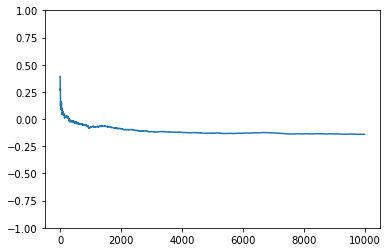

final result is 
 [[ 0.19879623]
 [-0.18758725]
 [ 0.98879103]]
compare with the theory result 
 [[ 0.1941563 ]
 [-0.19650796]
 [ 1.00235165]]


In [112]:
def Robbins_Monro_Regression(N = 10000, alpha = 0.6):
    R = np.random.multivariate_normal(mu, S, N)
    x = np.random.random(n)
    x = x/np.sum(x)
    w = [x.reshape(n,1)]     # initialization with equal value
    w_hist = [x.reshape(n,1)]
    rg = range(N)
    if N > 1e4 :
        rg = tqdm(rg)
    for i in rg:
        w_tmp = w[-1] - 10.*f(w[-1], R[i])/np.power(i+1,alpha)
        w.append(w_tmp)
        w_hist.append(w_tmp/np.sum(w_tmp))
    plot_hist(w_hist)
    print("final result is \n {}".format(w[-1]/np.sum(w[-1])))
    print("compare with the theory result \n {}".format(theory_answer(S)))
    return w[-1]/np.sum(w[-1]),w,w_hist
x,_,_ = Robbins_Monro_Regression(N = 1000000,alpha = 0.6)

## 3.2

In [109]:
def S_rho(rho):
    D = np.diag([.1, .14, .02])
    # rho = 0.5
    K = np.array([[1, rho, 0],
                 [rho, 1, rho],
                 [0, rho, 1]])
    S = np.matmul(np.matmul(D, K), D)
    return S

In [110]:
def UQSA( mu, rho_min, rho_max, Mk, u0 = '', K = 10000, mk = 10, n=3,step_multi = 1.0):
    if u0=='' : 
        u0 = np.random.randn(mk,n)
    u = np.zeros(shape = (mk,n))    
    assert len(u0) == mk
    
    Legendre_basis = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([rho_min, rho_max])) for i in range(mk)]
        
    def W(rho,u0,Legendre_basis = Legendre_basis):
        return np.sum([u0[j]*Legendre_basis[j](rho) for j in range(mk)],axis = 0)
    
    for k in tqdm(range(K)):
        
        rho = []
        R = []
        for s in range(Mk):
            r = np.random.uniform(low = rho_min, high = rho_max)
            rho.append(r)
            S = S_rho(r)
            R.append(np.random.multivariate_normal(mu, S))
            
        for i in range(mk):
            expect = 0.0
            for s in range(Mk):
                w = W(rho[s],u0)
                w = w.reshape(n,1)
                expect = expect + f(w,R[s])*Legendre_basis[i](rho[s])
            expect = expect.reshape(1,n) / Mk
            
            u[i] = u0[i] - step_multi * expect/(k+1)
            
        u0 = u
#     Sum = np.sum(u)
#     return [x/np.sum(x) for x in u]  #TODO as projection of A to be defined
    return u

In [37]:
UQSA(mu, 0.6,0.8,100,K = 100)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-35-951d0cbce78a>:20: RuntimeWarning: covariance is not positive-semidefinite.
  R.append(np.random.multivariate_normal(mu, S))
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


array([[ 0.23844418, -0.85760997, -1.71356754],
       [ 1.05490993,  0.59453913,  1.2550954 ],
       [-0.37243051, -1.09821084,  2.11208442],
       [ 0.43663043, -2.51738529, -0.76649079],
       [-0.98746184, -2.84264178,  0.85688883],
       [ 1.08766823, -0.49721432, -0.64768025],
       [-0.26710926, -0.58081462,  2.93931166],
       [-1.11645207, -0.56227068, -1.53482016],
       [ 1.34725873,  0.8042765 ,  0.65439833],
       [ 0.09696422,  0.45687061,  0.03869902],
       [ 0.98976388,  0.91928707,  0.55470719],
       [ 0.54315826, -0.92891295, -1.40855926]])

In [118]:
def result_UQSA(r, mk, K = 100):
    u = UQSA(mu, 0.6,0.8,100, mk = mk, K = K)
    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([0.6, 0.8])) for i in range(mk)]
    result = np.zeros(3)
    for j in range(mk):
        result = result + B[j](r)*u[j]
    return result/np.sum(result)
        

In [119]:
result_UQSA(0.7, 10,500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:23<00:00,  6.00it/s]


array([0.19088136, 0.22332848, 0.58579016])

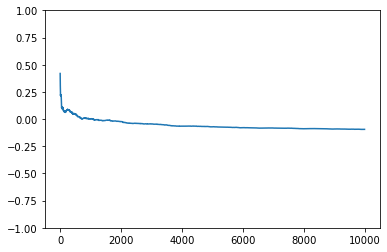

final result is 
 [[ 0.24493223]
 [-0.0944143 ]
 [ 0.84948207]]
compare with the theory result 
 [[ 0.1941563 ]
 [-0.19650796]
 [ 1.00235165]]


In [111]:
S = S_rho(rho=0.7)
_,_,_ = Robbins_Monro_Regression(alpha=0.6)